In [1]:
import os
import matplotlib.pyplot as plt
import json

In [88]:
src_dir = "/cm/archive/namlh35/SATD/results/maldonado_projects_full"
ori_name = "{}-satd-{}"
tesoro_name = "{}-extra-tesoro-satd-{}"

methods = ["codebert-base", "roberta-base"]
method_names = ["CodeBERT", "RoBERTa"]
scenarios = ["identification", "classification", "detection"]


In [90]:
def read_rs(folder):
    projects = []
    f1 = []
    for proj in os.listdir(folder):
        if proj.startswith(("summary", "tesoro")):
            continue
        with open(os.path.join(folder, proj, f"{proj}_predict_score.json"), "r") as f:
            rs = json.load(f)
        
        if len(proj.split("-")) > 1:
            proj_name = "-".join(proj.split("-")[:-1])
        else:
            proj_name = proj
        projects.append(proj_name)
        # projects.append(proj)
        f1.append(rs["macro_f1"])
    return projects, f1

/cm/archive/namlh35/SATD/viz/ipykernel_181990/694507219.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[mid][sid].set_xticklabels(ori_rs[0], rotation=90, fontsize=10)
/cm/archive/namlh35/SATD/viz/ipykernel_181990/694507219.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[mid][sid].set_xticklabels(ori_rs[0], rotation=90, fontsize=10)
/cm/archive/namlh35/SATD/viz/ipykernel_181990/694507219.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[mid][sid].set_xticklabels(ori_rs[0], rotation=90, fontsize=10)


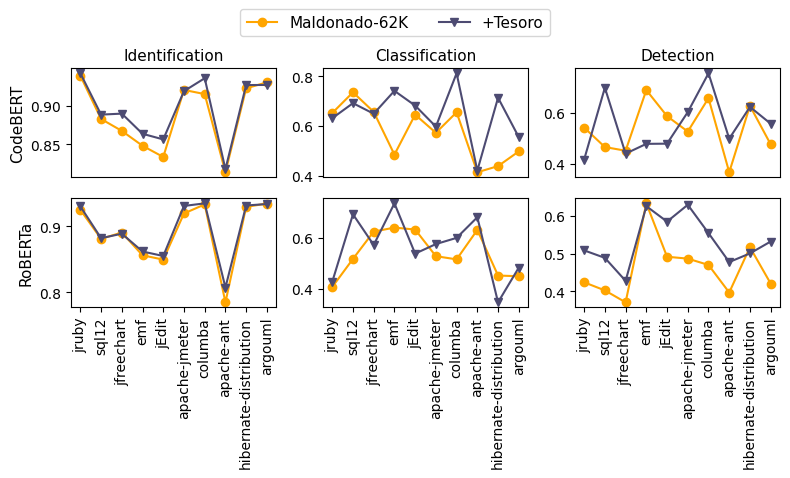

In [91]:
fig, axs = plt.subplots(2,3, figsize=(8,4.5))
for mid, method in enumerate(methods):

    for sid, scenario in enumerate(scenarios):
        ori_rs = read_rs(os.path.join(src_dir, ori_name.format(method, scenario)))
        tesoro_rs = read_rs(os.path.join(src_dir, tesoro_name.format(method, scenario)))
        axs[mid][sid].plot(ori_rs[0], ori_rs[1], color='orange', marker='o', label="Maldonado-62K")
        axs[mid][sid].plot(tesoro_rs[0], tesoro_rs[1], color='#4d4b72', marker='v', label="+Tesoro")

        if mid == 0:
            axs[mid][sid].set_xticks([])
            axs[mid][sid].set_title(scenario.capitalize(),fontsize=11)
        else:
            axs[mid][sid].set_xticklabels(ori_rs[0], rotation=90, fontsize=10)
        
        if sid == 0:
            axs[mid][sid].set_ylabel(method_names[mid],fontsize=11)

handles, labels = axs[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncols=2, bbox_to_anchor=[0.5, 1.07], fontsize= 11)

plt.tight_layout()
# plt.show()
plt.savefig('rq1_projects.pdf', bbox_inches='tight')

## Loss improvement

In [1]:
!export HF_HOME="/cm/archive/namlh35/cache"
!export HF_DATASETS_CACHE="/cm/archive/namlh35/cache"
!export https_proxy=http://10.16.32.11:8080

In [1]:
import os
import matplotlib.pyplot as plt
import json
from datasets import load_dataset
import torch

/cm/archive/namlh35/namlh/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
datasrc = "/cm/archive/namlh35/SATD/data/maldonado_projects_full"
resrc = "/cm/archive/namlh35/SATD/results/maldonado_projects_full"
model = "codebert-base"
task = "detection"
baseline = os.path.join(resrc,"{}-satd-{}".format(model, task))
method = os.path.join(resrc,"{}-extra-tesoro-satd-{}".format(model, task))

In [5]:
projects = os.listdir(datasrc)
tesoro = load_dataset("json", data_files = "/cm/archive/namlh35/SATD/My_dataset/BATCH1/tesoro_as_extra_data.json", split= 'train')
ts_classification = tesoro.filter(lambda x: x["classification"] != "WITHOUT_CLASSIFICATION")

data_stas = {}
for project in projects:
    train_data = load_dataset("json", data_files = [os.path.join(datasrc, x) for x in projects if x != project], split="train")
    project = project.split(".")[0]
    data_stas[project] = {}
    for task in ["detection", "classification", "identification"]:
        if task == "classification":
            data_stas[project]["maldonado"] = len(train_data.filter(lambda x: x["classification"] != "WITHOUT_CLASSIFICATION"))
            data_stas[project]["tesoro"] = len(ts_classification)
        else:
            data_stas[project]["maldonado"] = len(train_data)
            data_stas[project]["tesoro"] = len(tesoro)

print(json.dumps(data_stas, indent=4))

{
    "jEdit-4": {
        "maldonado": 33540,
        "tesoro": 4259
    },
    "apache-ant-1": {
        "maldonado": 35170,
        "tesoro": 4259
    },
    "sql12": {
        "maldonado": 33466,
        "tesoro": 4259
    },
    "jfreechart-1": {
        "maldonado": 35696,
        "tesoro": 4259
    },
    "hibernate-distribution-3": {
        "maldonado": 35713,
        "tesoro": 4259
    },
    "emf-2": {
        "maldonado": 35462,
        "tesoro": 4259
    },
    "columba-1": {
        "maldonado": 34083,
        "tesoro": 4259
    },
    "apache-jmeter-2": {
        "maldonado": 34113,
        "tesoro": 4259
    },
    "argouml": {
        "maldonado": 32703,
        "tesoro": 4259
    },
    "jruby-1": {
        "maldonado": 34475,
        "tesoro": 4259
    }
}


In [4]:
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoModel,
    AutoTokenizer)

tokenizers={}
baseline_models = {}
method_models = {}


for project in os.listdir(method):
    if os.path.isfile(os.path.join(method, project)) or project.startswith("tesoro"):
        continue

    tokenizers[project] = AutoTokenizer.from_pretrained(os.path.join(method, project))
    method_models[project] = AutoModelForSequenceClassification.from_pretrained(os.path.join(method, project), config=AutoConfig.from_pretrained(os.path.join(method, project)))
    baseline_models[project] = AutoModelForSequenceClassification.from_pretrained(os.path.join(baseline, project), config=AutoConfig.from_pretrained(os.path.join(method, project)))

In [7]:


def cal_loss(model, tokenizer, data):
    model.eval()
    label_to_id = model.config.label2id
    def preprocess_function(examples):
       
        # examples["sentence"] = examples['comment']
        # if data_args.remove_special_tokens:
        #     for i in range(len(examples["sentence"])):
        #         examples["sentence"][i] = " ".join([x for x in examples["sentence"][i].split(" ") if x.lower() not in special_tokens])

        result = tokenizer(examples["comment"], padding=False, max_length=min(256+ 512,  tokenizer.model_max_length), truncation=True)
        # print(result)
        result["labels"] = [(label_to_id[str(l)] if l != -1 else -1) for l in examples["classification"]]
        return result

    data = data.map(
        preprocess_function,
        batched=True,
    ).remove_columns(['projectname', 'classification', 'comment'])
    
    for dp in data:
        print(tokenizer.convert_ids_to_tokens(dp["input_ids"]))
        for attr in dp:
            dp[attr] = torch.tensor(dp[attr])
        with torch.no_grad():
            print(model(input_ids = dp["input_ids"].unsqueeze(0), attention_mask = dp["attention_mask"].unsqueeze(0), labels=dp['labels']))

    



In [9]:
projects = os.listdir(datasrc)
for project in projects:
    data = load_dataset("json", data_files=[os.path.join(datasrc, x) for x in projects if x != project], split="train")
    project = project.split(".")[0]
    cal_loss(baseline_models[project], tokenizers[project], data)

Generating train split: 33540 examples [00:00, 94188.27 examples/s] 
Map: 100%|██████████| 33540/33540 [00:02<00:00, 11550.93 examples/s]


['<s>', 'fix', 'me', 'Ġformat', 'ters', 'Ġare', 'Ġnot', 'Ġthread', '-', 'safe', '</s>']
SequenceClassifierOutput(loss=tensor(0.0242), logits=tensor([[ 4.6324, -1.2158, -0.9110, -0.9704,  0.2566, -1.9524]]), hidden_states=None, attentions=None)
['<s>', 'xxx', ':', 'Ġ(', 'jon', 'Ġske', 'et', ')', 'Ġthe', 'Ġcomment', 'Ġ"', 'if', 'Ġit', 'Ġhasn', "'t", 'Ġbeen', 'Ġdone', 'Ġalready', '"', 'Ġmay', 'Ġnot', 'Ġbe', 'Ġstrictly', 'Ġtrue', '.', 'Ġwrapper', '.', 'may', 'bec', 'on', 'figure', '()', 'Ġwon', "'t", 'Ġconfigure', 'Ġthe', 'Ġsame', 'Ġattributes', '/', 'text', 'Ġmore', 'Ġthan', 'Ġonce', ',', 'Ġbut', 'Ġit', 'Ġmay', 'Ġwell', 'Ġadd', 'Ġthe', 'Ġchildren', 'Ġagain', ',', 'Ġunless', 'Ġi', "'ve", 'Ġmissed', 'Ġsomething', '.', '</s>']
SequenceClassifierOutput(loss=tensor(0.0602), logits=tensor([[ 4.2214,  1.1667, -1.6182, -1.4982, -1.4575, -1.0126]]), hidden_states=None, attentions=None)
['<s>', 'i', 'Ġhate', 'Ġto', 'Ġadmit', 'Ġit', ',', 'Ġbut', 'Ġwe', 'Ġdon', "'t", 'Ġknow', 'Ġwhat', 'Ġhappened', 'Ġ

KeyboardInterrupt: 

In [ ]:
rs = {
    'codebert-detection': {
        "jEdit-4": 0.1634748316004156,
        "apache-ant-1.7.0": 0.16855969086540568,
        "sql12": 0.11505584112327222,
        "jfreechart-1":0.13314714632769606,
        "hibernate-distribution-3": 0.3646662894236317,
        "emf-2": 0.1021815406888267,
        "columba-1": 0.09093320768004919,
        "apache-jmeter-2": 0.18130516765425853,
        "argouml": 0.5469281308746492,
        "jruby-1": 0.25052335959872446
    },
    'codebert-tesoro-detection': {
        "jEdit-4": 0.15205292372254262,
        "apache-ant-1": 0.1745179217648276,
        "sql12": 0.11620934597850031,
        "jfreechart-1": 0.14381851025724035,
        "hibernate-distribution-3": 0.34244591621929815,
        "emf-2": 0.10131634972403916,
        "columba-1": 0.0822107752043961,
        "apache-jmeter-2": 0.16395949286518977,
        "argouml": 0.5844170428435022,
        "jruby-1": 0.27333175912207314
    },
    "roberta-base-detection": {
        "jEdit-4": 0.15855851151190636,
        "apache-ant-1": 0.18882150477641835,
        "sql12": 0.13778597972577417,
        "jfreechart-1": 0.14104917188290125,
        "hibernate-distribution-3": 0.3389163291721615,
        "emf-2": 0.08519937434762882,
        "columba-1": 0.10906705852423634,
        "apache-jmeter-2": 0.169323067165126,
        "argouml": 0.5010569283313396,
        "jruby-1": 0.30974718718771105
    },
    "roberta-base-tesoro-detection": {
        "jEdit-4": 0.1419255516658022,
        "apache-ant-1": 0.17492261393552885,
        "sql12": 0.13502650165396377,
        "jfreechart-1": 0.16311923402510517,
        "hibernate-distribution-3": 0.31128656217815276,
        "emf-2": 0.08340427602026154,
        "columba-1": 0.09931036041712962,
        "apache-jmeter-2": 0.14775383063946976,
        "argouml": 0.5230677979283819,
        "jruby-1": 0.2841109776406455
    },
    "roberta-base-classification": {
        "jEdit-4": 0.7210352711188488,
        "apache-ant-1": 0.8156786926331059,
        "sql12": 0.8773353099822998,
        "jfreechart-1": 1.667209925474944,
        "hibernate-distribution-3": 0.8796306218741075,
        "emf-2": 0.7877061337600519,
        "columba-1": 1.518694019317627,
        "apache-jmeter-2": 1.0835919832881493,
        "argouml": 1.3533450343087643,
        "jruby-1": 1.2990559764530347
    },
    "roberta-base-tesoro-classification": {
        "jEdit-4": 0.7680757983118041,
        "apache-ant-1": 0.7810899942151962,
        "sql12": 0.8804670615239186,
        "jfreechart-1": 1.8332589467366536,
        "hibernate-distribution-3": 0.9465294896431689,
        "emf-2": 0.7109192418463436,
        "columba-1": 1.3981881439685822,
        "apache-jmeter-2": 0.9979325789439527,
        "argouml": 1.5026752503950205,
        "jruby-1": 1.2911680988643481},
        
    "bert-base-detection": {
        "jEdit-4": 0.20250969030850952,
        "apache-ant-1": 0.19773436433711686,
        "sql12": 0.14451373845913554,
        "jfreechart-1": 0.16174256112700705,
        "hibernate-distribution-3": 0.3997531282338015,
        "emf-2": 0.10301289124657192,
        "columba-1": 0.11697627699976663,
        "apache-jmeter-2": 0.19092467638599633,
        "argouml": 0.5463513247949846,
        "jruby-1": 0.28563888274346705
    },
    "bert-base-tesoro-detection": {
        "jEdit-4": 0.19413240548970712,
        "apache-ant-1": 0.19764970281188715,
        "sql12": 0.1306666369973999,
        "jfreechart-1": 0.17019747646191233,
        "hibernate-distribution-3": 0.35400044312992124,
        "emf-2": 0.10660475229869003,
        "columba-1": 0.11218011151395661,
        "apache-jmeter-2": 0.17298726169316275,
        "argouml": 0.5547806726968731,
        "jruby-1": 0.3306770344655045
    },

    "graphcodebert-base-detection": {
        "jEdit-4": 0.11471312234620583,
        "apache-ant-1": 0.14316848304550783,
        "sql12": 0.09029181827384805,
        "jfreechart-1": 0.12344071345951797,
        "hibernate-distribution-3": 0.27977190308815014,
        "emf-2": 0.0863287333029697,
        "columba-1": 0.08629974598050891,
        "apache-jmeter-2": 0.12457554555530333,
        "argouml": 0.4658682701953272,
        "jruby-1": 0.2072916088733367
    },
    "graphcodebert-base-tesoro-detection": {
        "jEdit-4": 0.13738276450508774,
        "apache-ant-1": 0.18794661723512304,
        "sql12": 0.11164012584174465,
        "jfreechart-1": 0.1945758524022038,
        "hibernate-distribution-3": 0.385262793694085,
        "emf-2": 0.11334967358039136,
        "columba-1": 0.1087047139034484,
        "apache-jmeter-2": 0.17442962777562426,
        "argouml": 0.6182865899807813,
        "jruby-1": 0.31469990602072423
    }
}